In [1]:
################################################################
# Scirpt_Name: PRISM_Masking.py                                #
# Purpose(s): 1. Looping through different year concatenated   #
#                daily precipitation data, masking datasets    #
#                over watershed of interests.                  #
#             2. Concatenate the masked datasets into one file #
#                and save at local disk                        #
#             3. Optional: Maybe calculate mean areal values   #
#                          and transform into .CSV files       #
################################################################
# Written by Lujun Zhang @ U of Oklahoma 03/29/2020            #
# REVISION HISTORY                                             #
# 20200329 -- Initial version completed by Lujun @ OU          #
################################################################
# Requie packages: Numpy, Pandas, necCDF4                      #
################################################################

In [2]:
import numpy as np
import numpy.ma as ma
import pandas as pd
from datetime import timedelta
import sys
import os
import time
import datetime
from netCDF4 import Dataset  
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import interp
import gdal
import warnings
warnings.filterwarnings('ignore')

In [3]:
###########################################################################
## Before anything Remerber to make sure the long & latitude between     ##
#  input shapefile and PRISM dataset are consistent                       #
## ----------------------------------------------------------------------##
#  Here we shift input shapefile's longitude so it has a range of [0,360] #
#  This was done by using the ogr2ogr tool within the command line window #
###########################################################################
# The example code using Mill.shp as an example are listed below:
# ogr2ogr Mill_Shifted.shp Mill.shp -dialect sqlite -sql "SELECT ShiftCoords(geometry,180,0) FROM Mill"

In [4]:
# Clipping NMME Members Using shapefile
def PRISM_Prec_Mask(ncInput,ShpFileDirec):
    '''
    1) This function:
    - clipping & Masking the origional PRISM dataset accorindg to 
      the input shapefile;
    - returns a masked Numpy Array over desired region
    2) The input elements are explainted below:
    - NcInput: a NetCDF4.Dataset object
    - ShpFileDirec: Shape file's directory in str format
    
    '''
    #read shapefile   
    shpDS = ogr.Open(ShpFileDirec)
    shpLyr = shpDS.GetLayer()
    Envelop = shpLyr.GetExtent() 
    xmin,xmax,ymin,ymax = [Envelop[0],Envelop[1],Envelop[2],Envelop[3]]    #Your extents as given above
    xmin = xmin-0.04168701
    xmax = xmax+0.04168701
    ymin = ymin-0.041664124
    ymax = ymax+0.041664124
    mask_RES = []
    ######################################################
    #                Extract Origin Data                 #
    ######################################################
    lon_Ori = ncInput['Lon'][:]
    lat_Ori = ncInput['Lat'][:]
    varData_Ori = ncInput['Prec'][:]  
    ######################################################
    #                   Create mask                      #
    ######################################################
    if len(mask_RES) == 0 :
        #get boundary and xs ys
        lat_bnds, lon_bnds = [ymin-0.04, ymax], [xmin-0.04,xmax]
        lat_inds = np.where((lat_Ori >= (lat_bnds[0])) & (lat_Ori <= lat_bnds[1]))
        lon_inds = np.where((lon_Ori >= (lon_bnds[0])) & (lon_Ori <= lon_bnds[1]))
        ncols = len(lon_inds[0])
        nrows = len(lat_inds[0])
        #nreftime = len(ref_Ori)
        #create geotransform
        xres = (xmax - xmin) / float(ncols)
        yres = (ymax - ymin) / float(nrows)
        geotransform = (xmin,xres,0,ymax,0,-yres)
        #create mask
        mask_DS = gdal.GetDriverByName('MEM').Create('', ncols, nrows, 1 ,gdal.GDT_Int32)
        mask_RB = mask_DS.GetRasterBand(1)
        mask_RB.Fill(0) #initialise raster with zeros
        mask_RB.SetNoDataValue(-32767)
        mask_DS.SetGeoTransform(geotransform)
        maskvalue = 1
        err = gdal.RasterizeLayer(mask_DS, [maskvalue], shpLyr)
        mask_DS.FlushCache()
        mask_array = mask_DS.GetRasterBand(1).ReadAsArray()    
        mask_RES = ma.masked_equal(mask_array, 255)          
        ma.set_fill_value(mask_RES, -32767)
        mask = np.expand_dims(np.logical_not(np.flipud(mask_RES.mask)),0)
    ######################################################
    #                     Set Mask                       #
    ######################################################   
    var_subset = varData_Ori[:, min(lat_inds[0]):max(lat_inds[0])+1, min(lon_inds[0]):max(lon_inds[0])+1]
    var_subset.__setmask__(mask) # update mask (flipud is reverse 180)
    lat_subset = lat_Ori[lat_inds] 
    lon_subset = lon_Ori[lon_inds]
        

    return var_subset, lon_subset, lat_subset

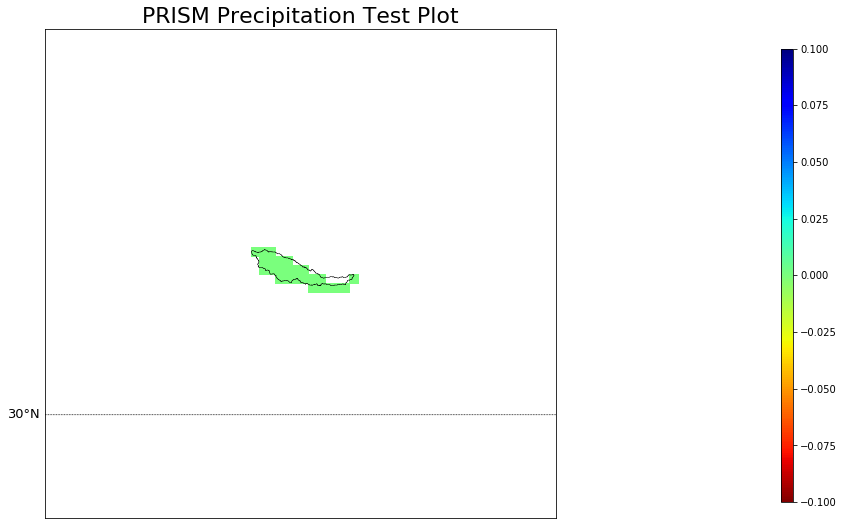

In [9]:
# Exp Plot
SHP = 'C:/users/Zhan0101/desktop/20200329 Selected_watersheds/Wimberly_Shifted.shp'
NC = Dataset('F:/PRISM_Daily_Precipitation/Organized/PRISM_2001_Daily_Precipitation.nc')
data_tab = PRISM_Prec_Mask(NC,SHP)

Long = data_tab[1]
Lat = data_tab[2]
Prec = data_tab[0]
Prec = Prec[110,:,:]
#Long = Lon
#Lat = Lat
#Prec = Data[1,:,:]

lon_min=np.min(Long)-1; lon_max=np.max(Long)+1
lat_min=np.min(Lat)-1; lat_max=np.max(Lat)+1

plt.figure(figsize=(16,9))
plt.title('PRISM Precipitation Test Plot',fontsize=22)
m=Basemap(projection='mill',llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l')
shp_info = m.readshapefile("C:/users/Zhan0101/desktop/20200329 Selected_watersheds/Wimberly_Shifted",'MILL')

lon,lat=np.meshgrid(Long,Lat)
lon,lat=m(lon,lat)
m.drawcoastlines(linewidth=1)
m.drawstates(linewidth=1.5)
m.drawcountries(linewidth=2)
m.drawparallels(np.arange(-90, 90,30), labels=[1,0,0,0], fontsize=13,linewidth=0.8)
m.drawmeridians(np.arange(-180, 180, 45), labels=[0,0,0,1], fontsize=13,linewidth=0.8)
cmap = plt.cm.jet_r
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Prec))
#norm = mpl.colors.Normalize(vmin=0, vmax=0.01)
cf = plt.pcolormesh(lon,lat,Prec,cmap=cmap,norm=norm)
#cax = ax[1].pcolor(lon,lat,Prec[450,0,3],camp=camp)
cax=plt.axes([0.93, 0.15, 0.01,0.7])
cbar = plt.colorbar(cf,cax=cax)

In [14]:
# Shapefile information specification
SHP_Names = ['Delaware_Shifted.shp','Mill_Shifted.shp','Sycamore_Shifted.shp','Wimberly_Shifted.shp']

In [18]:
year_range = range(1981,2020)
for i in SHP_Names[1:]:
    Input_SHP = 'C:/users/Zhan0101/desktop/20200329 Selected_watersheds/'+i
    for j in year_range:
        Input_NC = 'F:/PRISM_Daily_Precipitation/Organized/PRISM_'+str(j)+'_Daily_Precipitation.nc'
        Input_NC = Dataset(Input_NC)
        data_tab, Lon, Lat = PRISM_Prec_Mask(Input_NC,Input_SHP)
        if (j == year_range[0]):
            Data = data_tab
        elif (j == year_range[-1]):
            Data = np.concatenate((Data,data_tab),axis=0)  
            # Saving as NC file
            Out_Direc = 'F:/PRISM_Daily_Precipitation/Organized/'+i[:-12]+'_Daily_Precipitation.nc'
            ncOutput = Dataset(Out_Direc, 'w', format='NETCDF4')
            ncOutput.createDimension('Lon', np.size(Lon))
            ncOutput.createDimension('Lat', np.size(Lat))
            ncOutput.createDimension('T', np.shape(Data)[0])
            # Add lat Variable
            var_out_Y = ncOutput.createVariable('Lat','f',("Lat"))
            ncOutput.variables['Lat'][:] = Lat[:]
            # Add lon Variable
            var_out_X = ncOutput.createVariable('Lon','f',("Lon"))
            ncOutput.variables['Lon'][:] = Lon[:]
            # Add time Variable
            var_out_S = ncOutput.createVariable('T','f',("T"))
            ncOutput.variables['T'][:] = np.arange(np.shape(Data)[0])[:]
            # Add data Variable
            var_out_data = ncOutput.createVariable('Prec', 'f',("T","Lat","Lon"))
            ncOutput.variables['Prec'][:,:,:] = Data[:,:,:]
            # attr
            ncOutput.history = "Created datatime " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + " by LujunZ at OU"
            ncOutput.source  = "netCDF4 under python 3.6.5"
            ncOutput.close()  # close the new file  
            
            mean_areal_value = np.mean(Data,axis=(1,2))
            # Svaing mean areal value into .CSV format at local disk
            idx = pd.date_range(start=str(year_range[0])+'/01/01', end=str(year_range[-1])+'/12/31', freq="d")
            mean_areal_value = pd.DataFrame(data=mean_areal_value,index=idx,columns=None)
            mean_areal_value.to_csv('F:/PRISM_Daily_Precipitation/'+i[:-12]+'.csv')
        else:
            Data = np.concatenate((Data,data_tab),axis=0)
        print(i[:-12]+' '+str(j)+' data masked!')

Mill 1981 data masked!
Mill 1982 data masked!
Mill 1983 data masked!
Mill 1984 data masked!
Mill 1985 data masked!
Mill 1986 data masked!
Mill 1987 data masked!
Mill 1988 data masked!
Mill 1989 data masked!
Mill 1990 data masked!
Mill 1991 data masked!
Mill 1992 data masked!
Mill 1993 data masked!
Mill 1994 data masked!
Mill 1995 data masked!
Mill 1996 data masked!
Mill 1997 data masked!
Mill 1998 data masked!
Mill 1999 data masked!
Mill 2000 data masked!
Mill 2001 data masked!
Mill 2002 data masked!
Mill 2003 data masked!
Mill 2004 data masked!
Mill 2005 data masked!
Mill 2006 data masked!
Mill 2007 data masked!
Mill 2008 data masked!
Mill 2009 data masked!
Mill 2010 data masked!
Mill 2011 data masked!
Mill 2012 data masked!
Mill 2013 data masked!
Mill 2014 data masked!
Mill 2015 data masked!
Mill 2016 data masked!
Mill 2017 data masked!
Mill 2018 data masked!
Mill 2019 data masked!
Sycamore 1981 data masked!
Sycamore 1982 data masked!
Sycamore 1983 data masked!
Sycamore 1984 data mas

In [16]:
mean_areal_value = np.mean(Data,axis=(1,2))
# Svaing mean areal value into .CSV format at local disk
idx = pd.date_range(start=str(year_range[0])+'/01/01', end=str(year_range[-1])+'/12/31', freq="d")
mean_areal_value = pd.DataFrame(data=mean_areal_value,index=idx,columns=None)
mean_areal_value.to_csv('F:/PRISM_Daily_Precipitation/'+i[:-12]+'.csv')

In [10]:
# Saving as NC file
Out_Direc = 'F:/PRISM_Daily_Precipitation/Organized/'+i[:-12]+'_Daily_Precipitation.nc'
ncOutput = Dataset(Out_Direc, 'w', format='NETCDF4')
ncOutput.createDimension('Lon', np.size(Lon))
ncOutput.createDimension('Lat', np.size(Lat))
ncOutput.createDimension('T', np.shape(Data)[0])
# Add lat Variable
var_out_Y = ncOutput.createVariable('Lat','f',("Lat"))
ncOutput.variables['Lat'][:] = Lat[:]
# Add lon Variable
var_out_X = ncOutput.createVariable('Lon','f',("Lon"))
ncOutput.variables['Lon'][:] = Lon[:]
            # Add time Variable
var_out_S = ncOutput.createVariable('T','f',("T"))
ncOutput.variables['T'][:] = np.arange(np.shape(Data)[0])[:]
            # Add data Variable
var_out_data = ncOutput.createVariable('Prec', 'f',("T","Lat","Lon"))
ncOutput.variables['Prec'][:,:,:] = Data[:,:,:]
            # attr
ncOutput.history = "Created datatime " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + " by LujunZ at OU"
ncOutput.source  = "netCDF4 under python 3.6.5"
ncOutput.close()  # close the new file  
            
mean_areal_value = np.mean(data,axis=(1,2))
            # Svaing mean areal value into .CSV format at local disk
idx = pd.date_range(start=str(year_range[0])+'/01/01', end=str(year_range[-1])+'/12/31', freq="d")
mean_areal_value = pd.DataFrame(data=mean_areal_value,index=idx,columns=None)
mean_areal_value.to_csv('F:/PRISM_Daily_Precipitation/'+i[:-12]+'.csv')

IndexError: size of data array does not conform to slice